In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [3]:
# Load datasets
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")

In [4]:
# Merge datasets for comprehensive analysis
customer_transactions = pd.merge(transactions, customers, on="CustomerID")

# Feature Engineering
# Total spending by each customer
customer_spending = customer_transactions.groupby("CustomerID")["TotalValue"].sum().rename("TotalSpending")

# Total quantity purchased by each customer
customer_quantity = customer_transactions.groupby("CustomerID")["Quantity"].sum().rename("TotalQuantity")

# Average transaction value for each customer
customer_avg_transaction = (customer_spending / customer_quantity).rename("AvgTransactionValue")

# Region as a categorical feature
customer_region = customers.set_index("CustomerID")["Region"]

# Combine features into a single DataFrame
customer_features = pd.concat([customer_spending, customer_quantity, customer_avg_transaction,
                                pd.get_dummies(customer_region)], axis=1)

In [5]:
# Fill missing values
customer_features.fillna(0, inplace=True)

In [6]:
# Normalize features for clustering
scaler = StandardScaler()
normalized_features = scaler.fit_transform(customer_features)

In [7]:
# Determine the optimal number of clusters using the Elbow Method
inertia = []
db_scores = []

for k in range(2, 11):  # Range of clusters: 2 to 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_features)
    inertia.append(kmeans.inertia_)
    db_scores.append(davies_bouldin_score(normalized_features, kmeans.labels_))

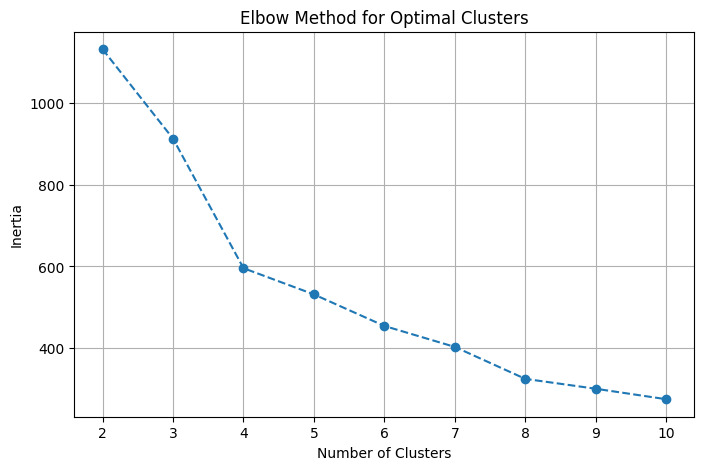

In [8]:
# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), inertia, marker='o', linestyle='--')
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.grid()
plt.show()

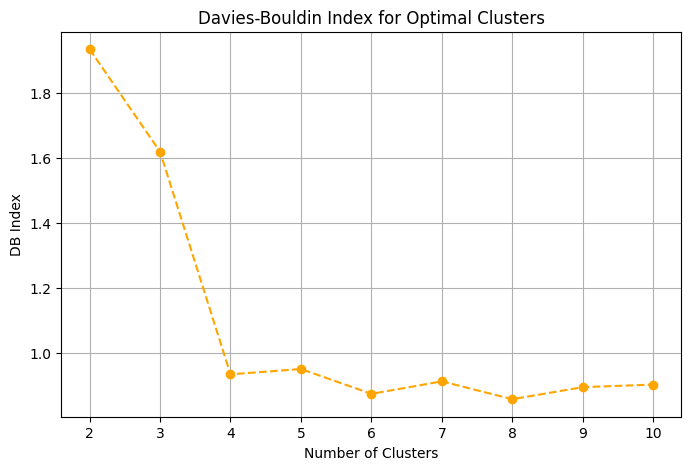

In [9]:
# Plot DB Index
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), db_scores, marker='o', linestyle='--', color='orange')
plt.title("Davies-Bouldin Index for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("DB Index")
plt.grid()
plt.show()

In [10]:
# Choose optimal number of clusters (based on Elbow/DB Index)
optimal_clusters = 4  # Example value; adjust based on plots
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(normalized_features)

In [11]:
# Add cluster labels to the dataset
customer_features["Cluster"] = clusters

# Evaluate Clustering
silhouette_avg = silhouette_score(normalized_features, clusters)
db_index = davies_bouldin_score(normalized_features, clusters)

print(f"Optimal Number of Clusters: {optimal_clusters}")
print(f"Silhouette Score: {silhouette_avg:.3f}")
print(f"Davies-Bouldin Index: {db_index:.3f}")

Optimal Number of Clusters: 4
Silhouette Score: 0.464
Davies-Bouldin Index: 0.934


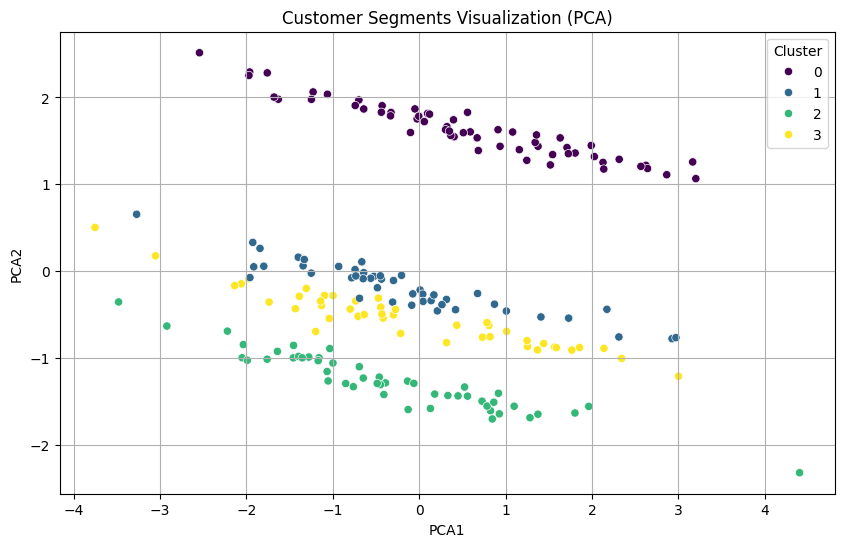

In [12]:
# Visualize Clusters using PCA (reduce to 2 dimensions)
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(normalized_features)
reduced_df = pd.DataFrame(reduced_features, columns=["PCA1", "PCA2"])
reduced_df["Cluster"] = clusters

plt.figure(figsize=(10, 6))
sns.scatterplot(x="PCA1", y="PCA2", hue="Cluster", data=reduced_df, palette="viridis")
plt.title("Customer Segments Visualization (PCA)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend(title="Cluster")
plt.grid()
plt.show()

In [13]:
# Save clustered data
customer_features.to_csv("Customer_Segments.csv")